# MNIST Interactive Graph

This program generates interactive graphs of a simple neural network learning 
to recognize handwritten digits from the MNIST dataset. This exmaple is mostly 
from the Tensor Flow [Beginner's example](https://www.tensorflow.org/get_started/mnist/beginners) 
on their website. One of the later graphs is a method I found from reading 
Christopher Olah blog entry [Visualizing Representations: Deep Learning and Human Beings](http://colah.github.io/posts/2015-01-Visualizing-Representations/)

Each snippter of code has a docstring (Red Text) before it explaining what it
does and inline documentation to explain the code line by line.

In [ ]:
"""
MNIST load

This loads the MNIST dataset from the tensor flow libraries. Run this
every time when starting the program but it only needs to be run once.
"""

#Create a neural network graph and setup training steps for 
# a neural network to use and learn from the MNIST dataset.

# Import modules necessary for MNIST Experiment
import tensorflow as tf

#Import example
from tensorflow.examples.tutorials.mnist import input_data
#Setup data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)


# Making the Model

Below focuses on utilizing tensor flow to make a neural network.

In [ ]:
"""
Model creation and Initialization

This snipper creates the model and initializes the values. This must
be run every time the program starts but only needs to be run once.
"""

import tensorflow as tf
import numpy as np

tf.reset_default_graph()

## Define model ##

# Define variables
x = tf.placeholder(tf.float32, [None, 784]) #Input values (N images by 784 pixels per image)
W = tf.Variable(tf.zeros([784, 10]))        #Weight values for input (784 pixels by 10 possible digits)
b = tf.Variable(tf.zeros([10]))             #Bias values for each digit
y = tf.nn.softmax(tf.matmul(x, W) + b)      #Output vector, Softmax(Wx + b)
# Define loss placeholder
y_ = tf.placeholder(tf.float32, [None, 10]) #How far is result from actual

# Define functions
# Create cross_entropy function based on loss and actual
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
# Instruct TensorFlow to attempt to minimize the cross_entropy using the Gradient Descent 
# Optimizer with a learning value of 0.5
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

# Initialize and save variables
init = tf.global_variables_initializer()

#add operations to save and restore all the variables
saver = tf.train.Saver([W,b])

#Start new Session
sess = tf.Session()

## Values used to collect data

#Number of steps to run
num_steps = 500
#Number of samples for data collection
n_samples = 1000
#Number of steps between sample collection
sample_gap = 5
#Define batch size
batch_size = 100


## Values that save data from training

#Save step numbers of each data point
points = num_steps // sample_gap + 1
step_nums = np.zeros(shape=(points))

#Save accuracy at all points
guess_accuracy = np.zeros(shape=(num_steps + 1))

#Define a way to save parameters for graph
graphs = np.zeros(shape=(points, n_samples, 2))
solutions = np.zeros(shape=(points, n_samples))
#Define a way to save weight images
weight_images = np.zeros(shape=(points, 10, 28, 28))

#Initialize variables
sess.run(init)

# Training the network

Below is code to train and log data about the neural 
network.

In [ ]:
"""
Train Neural Network

This snippter trains the neural network using the training data.
This can be a very slow process as it also creates graphics 
for visualizing the data as it trains the network. To change how 
often and how detailed the graphics are look in the previous 
snippet concerning Model creation and initialization.
"""
#Create a neural network and save values for display

# importing the required packages
import numpy as np
from sklearn import manifold

#Ignore divide by zero errors, only rare and on first frame
np.seterr(divide='ignore', invalid='ignore')

#Setup function for computing t-SNE for graphs
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    
# Define way to check session and run the function with test data
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))    #Define function to calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))  #Define function to display result

# Run training steps Num Steps times
for n in range(num_steps):
    #Get a batch of 100 images
    #Batch_x are the input images as a flattened 784 pixel vector
    #Batch_y is a vector of what number the image represents
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    
    #Evaluate current accuracy
    guess_accuracy[n] = sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
    
    #Run the session with the given data (Do one training step)
    sess.run(train_step, feed_dict={x: batch_x, y_: batch_y})
    
    #Log data every gap number of steps
    #Ignore index 0 as all values are set to zero and this can lead to errors
    #Add data point for last frame also
    if n // sample_gap < num_steps // sample_gap and \
            n % sample_gap == 0 or n == num_steps - 1:
        
        print("Calculating visual representation, step", n)
        #Load n samples from the training dataset
        #Batch_x are the input images as a flattened 784 pixel vector
        #Batch_y is a vector of what number the image represents
        batch_x, batch_y = mnist.train.next_batch(n_samples)
        X = sess.run(y, feed_dict={x:batch_x})
        
        index = n // sample_gap
        #If last frame, rig indices so it is put in last spot
        if (n == num_steps - 1):
            index = step_nums.shape[0] - 1
        
        # (This is slow but precomputed) Computing t-SNE projection
        tsne_vector = tsne.fit_transform(X)
        graphs[index] = tsne_vector;
        
        #Save the solution to this batch
        solutions[index] = np.array([np.argmax(group) for group in batch_y])
                         
        #Save weight images to display later
        weight_images[index] = np.array([np.reshape(sess.run(W)[np.arange(0,784), n], (-756,28)) for n in range(10)])
        
        #Save step number
        step_nums[index] = int(n + 1)
    
#Evaluate current accuracy
guess_accuracy[num_steps] = sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})

In [ ]:
"""
Evaulate model

This will take the current model and evaluate the accuracy. 
This model could have been trained or loaded from memory.
"""

#Evaluate the model

# Define way to check session and run the function with test data
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))    #Define function to calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))  #Define function to display result
a = sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
print("Accuray of prediction is " + 
      str(int(10000 * a) /100) + "%");

# Save and Load

Below are snippets describing how to save and load informaiton 
between session. Save to save data and the neural network 
and load to laod data from a previous session. By default there
should be an example in this folder.

In [ ]:
"""
Save Neural Network and Data

This snipper will save the neural network and data to a given folder.
This snippet will load the neural net from the folder simpleNN within the folder
and then will load graphing data from NNData subfolder within the folder.
"""

# Save the neural network and data out to the disk

import os
import numpy as np

print('What folder would you like to save to?')
print('By default, use the program uses this folder (' + os.getcwd() + ')')
path = input("path: ")

if not path:
    path = os.getcwd()

#Ensure that there is a directory to save the neural network in
if not os.path.isdir(os.path.join(path,"simpleNN")):
    os.makedirs(os.path.join(path,"simpleNN"))
save_path = saver.save(sess, os.path.join(path,"simpleNN","mnistNN.ckpt"))
#Log saving the file
print("Neural network saved to '%s'" % save_path)

#Ensure that there is a directory to save the data in
if not os.path.isdir(os.path.join(path,"NNData")):
    os.makedirs(os.path.join(path,"NNData"))
#Setup data and filenames to save
info = [graphs, solutions, weight_images, step_nums, guess_accuracy,
        np.array([num_steps, n_samples, sample_gap, batch_size])]
names = ["graphs.npy", "solutions.npy", "weight_images.npy", "step_nums.npy", 
         "guess_accuracy.npy", "meta_info.npy"]

#Iterate and save each piece of data
for index in range(len(info)):
    save_path = os.path.join(path,"NNData",names[index])
    np.save(save_path, info[index])
    print("Saved out data to '%s'" % save_path)

In [ ]:
"""
Load Neural Network and Data

This snipper will load the neural network and data from the given folder.
This snippet will load the neural net from the folder simpleNN within the folder
and then will load graphing data from NNData subfolder within the folder.
The neural network must first be initialized with the Model creation and
Initialization snippet from before.
"""

# Load data from disk to neural network and plotting information

import os
import numpy as np

print('What folder would you like to load from?')
print('By default, use the program uses this folder (' + os.getcwd() + ')')
path = input("path: ")

if not path:
    path = os.getcwd()
    
#Initialize variables
sess.run(init)

#Restore the neural network (if it exists)
save_path = os.path.join(path,"simpleNN", "mnistNN.ckpt.meta")
if os.path.isfile(save_path):
    # Restore neural network instead of loading values
    saver.restore(sess, os.path.join(path,"simpleNN", "mnistNN.ckpt"))
    print("Neural network loaded from file '%s'" % save_path)
    
save_path = os.path.join(path, "NNData", "graphs.npy")
if os.path.isfile(save_path):
    graphs = np.load(save_path)
    print("Graph data loaded from file '%s'" % save_path)

save_path = os.path.join(path, "NNData", "solutions.npy")
if os.path.isfile(save_path):
    solutions = np.load(save_path)
    print("Solution data loaded from file '%s'" % save_path)

save_path = os.path.join(path, "NNData", "weight_images.npy")
if os.path.isfile(save_path):
    weight_images = np.load(save_path)
    print("Weight image data loaded from file '%s'" % save_path)

save_path = os.path.join(path, "NNData", "step_nums.npy")
if os.path.isfile(save_path):
    step_nums = np.load(save_path)
    print("Step Number data loaded from file '%s'" % save_path)

save_path = os.path.join(path, "NNData", "guess_accuracy.npy")
if os.path.isfile(save_path):
    guess_accuracy = np.load(save_path)
    print("Guess accuracy data loaded from file '%s'" % save_path)
    
save_path = os.path.join(path, "NNData", "meta_info.npy")
if os.path.isfile(save_path):
    num_steps, n_samples, sample_gap, batch_size = np.load(save_path)
    print("Meta data loaded from file '%s'" % save_path)

# Viewing Results

Below are all methods for viewing the results from the neural network
and calculated data.

In [ ]:
"""
Plot the Accuracy over time
"""

# Plot the accuracy over time

import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(guess_accuracy * 100)
ax.set_xlabel('Number of Training Iterations')
ax.set_ylabel('Accuracy of Guesses (%)')
ax.set_title('Accuracy of Neural Network as it is trained')
plt.show()

<IPython.core.display.Javascript object>


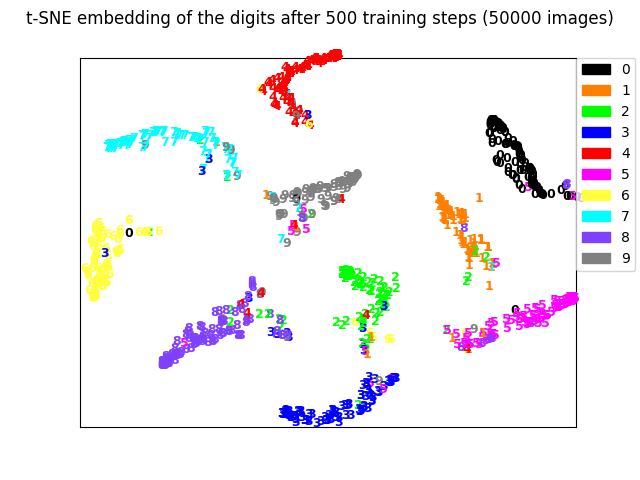

In [10]:
"""
Present the precompouter t-SNE information

When training, the neural network generated a graph of its progress 
over time. The graph samples the neural network every few steps 
and then takes the results of the guesses of the neural 
network and projects them onto a 2d plane to make a graph.
The network ouputs a 10d vector of the probability of
each digit that an image could be. The t-SNE algorithm takes these
vectors and projects them onto a 2d plane to show clustering of 
data in a human interpreatable format. 

This code is based on an example from 
https://www.analyticsvidhya.com/blog/2017/01/t-sne-implementation-r-python/
"""

# Take the precomputed information and make an interactive graph to showcase the neural network

#Import required libraies
from ipywidgets import interact
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Define colors for plotting numbers
colors = [(0,0,0,1),        #Black for zero
            (1, .5,0, 1),   #Orange for one
            (0, 1, 0, 1),   #Green for two
            (0, 0, 1, 1),   #Blue for three
            (1, 0, 0, 1),   #Red for four
            (1, 0, 1, 1),   #Magenta for five
            (1, 1, .25, 1), #Yellow for six
            (0, 1, 1, 1),   #Teal for seven
            (.5, .25, 1, 1),#Purple for eight
            (.5, .5, .5, 1)#Grey for nine
         ]

%matplotlib notebook

graph_fig = plt.figure()

def update(time_index = 0):
    frame = step_nums[time_index]
    
    #Update t-SNE Graph
    plt.figure(graph_fig.number)
    
    title="t-SNE embedding of the digits"
    #Save the vectors for this plot
    X = graphs[time_index]
    
    #Clear canvas
    graph_fig.clf()
    
    #Calculate min and max of graphs
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    #Normalize values based on input
    X = (X - x_min) / (x_max - x_min)     
    ax = plt.subplot(111)
    for i in range(n_samples):
        num = int(solutions[time_index][i])
        plt.text(X[i, 0], X[i, 1], str(num),
                 color=colors[num],
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([]), plt.yticks([])
    plt.suptitle(title + " after " + str(int(frame)) + " training steps (" + \
        str(int(frame * batch_size)) + " images)")
        
    patches = [mpatches.Patch(color=colors[i], label=str(i)) for i in range(10)]
    plt.legend(handles=patches,bbox_to_anchor=(1.001, 1), loc=2, borderaxespad=0.)
    plt.show()
    
interact(update, time_index = (0, len(graphs) - 1));

<IPython.core.display.Javascript object>


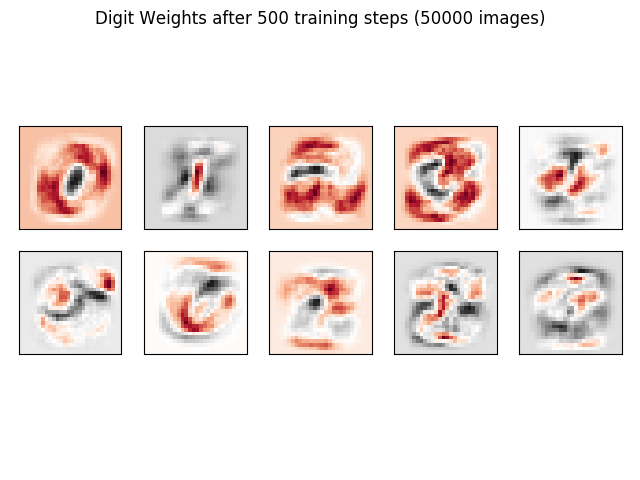

In [11]:
"""
Weight images

The neural network uses weights to calculate the probability that an image is or
is not a given number. This snippet takes those weights and uses
them to generate images as the neural network is trained.

"""

from ipywidgets import interact
from matplotlib import cm
from matplotlib import pyplot

%matplotlib notebook

dig_fig = plt.figure()

def update(time_index = 0):
    frame = step_nums[time_index]
    images = weight_images[time_index]

    for i in range(10):
        plt.subplot(2, 5, i + 1)
        pyplot.imshow(-images[i], interpolation='nearest', cmap=cm.RdGy)
        plt.xticks([]), plt.yticks([])
    
    plt.suptitle("Digit Weights after " + str(int(frame)) + " training steps (" + 
                  str(int(frame * batch_size)) + " images)")
    
    plt.tight_layout()
    pyplot.show()

interact(update, time_index = (0, len(graphs) - 1));